In [25]:
import math
import torch
import tqdm
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from gpytorch.models import ExactGP
from gpytorch.kernels import GaussianSymmetrizedKLKernel, ScaleKernel
from gpytorch.means import ConstantMean

import pandas as pd

data_dir = '../../data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
data = pd.read_csv(data_dir + 'concat/MWRA_seagrant_concat_batch.csv'
                   , parse_dates=['PROF_DATE_TIME_LOCAL'])
sal_and_ta = data[(data['SAL (PSU)'].notnull()) & (data['TA in (mmol/kgSW)'].notnull())]

In [33]:
train_x = sal_and_ta['SAL (PSU)'].values
train_y = sal_and_ta['TA in (mmol/kgSW)'].values
# Convert to torch tensor
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).float()

In [15]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

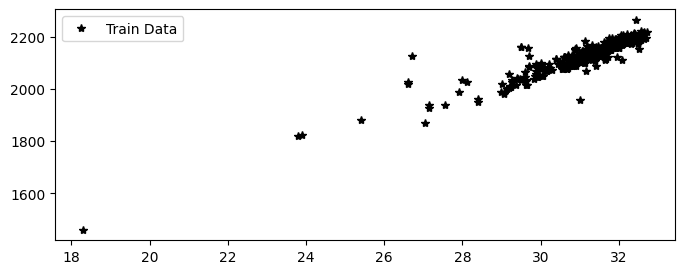

In [34]:
f, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.errorbar(train_x, train_y, fmt="k*", label="Train Data")
ax.legend()

In [58]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [59]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [60]:
training_iter = 500
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.25)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/500 - Loss: 41926.125   lengthscale: 0.693   noise: 0.693
Iter 2/500 - Loss: 31205.881   lengthscale: 0.826   noise: 0.826
Iter 3/500 - Loss: 23835.119   lengthscale: 0.970   noise: 0.970
Iter 4/500 - Loss: 18715.717   lengthscale: 1.122   noise: 1.122
Iter 5/500 - Loss: 15107.468   lengthscale: 1.278   noise: 1.277
Iter 6/500 - Loss: 12515.855   lengthscale: 1.434   noise: 1.434
Iter 7/500 - Loss: 10605.445   lengthscale: 1.588   noise: 1.590
Iter 8/500 - Loss: 9160.926   lengthscale: 1.739   noise: 1.743
Iter 9/500 - Loss: 8046.203   lengthscale: 1.884   noise: 1.892
Iter 10/500 - Loss: 7170.531   lengthscale: 2.024   noise: 2.036
Iter 11/500 - Loss: 6470.698   lengthscale: 2.157   noise: 2.175
Iter 12/500 - Loss: 5902.250   lengthscale: 2.284   noise: 2.308
Iter 13/500 - Loss: 5433.875   lengthscale: 2.405   noise: 2.434
Iter 14/500 - Loss: 5043.257   lengthscale: 2.519   noise: 2.555
Iter 15/500 - Loss: 4714.146   lengthscale: 2.627   noise: 2.670
Iter 16/500 - Loss: 4434.38

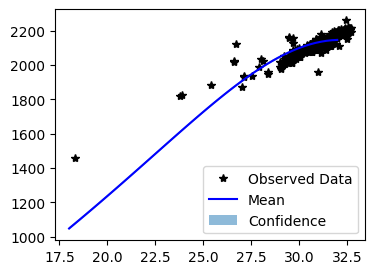

In [61]:
# Get into evaluation (predictive posterior) mode
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(18, 32, 51)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])